In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

from matplotlib import pyplot as plt
from matplotlib import animation
from seaborn import heatmap, color_palette

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject



# Utility Functions

In [2]:
from reservoir.utility import show_matrice, show_ei_matrix

# Reservoir functions

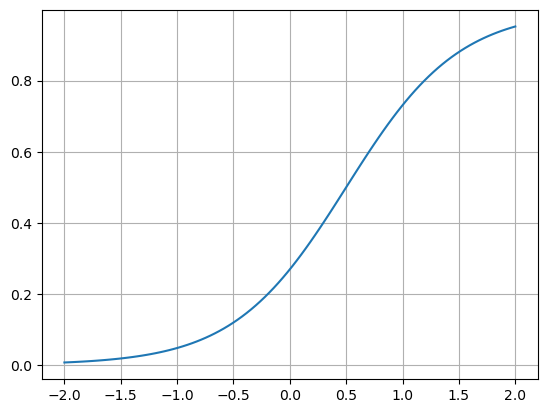

In [3]:
from importlib import reload
import reservoir.reservoir

from reservoir.reservoir import update_ei_reservoir, ridge_regression, train, run
from reservoir.reservoir import init_matrices
from reservoir.reservoir import synaptic_scaling, activation_target_definition, constant_synaptic_scaling
from reservoir.activation_functions import tanh, heaviside, sigmoid

reload(reservoir.reservoir)

# SEED
SEED = 3789

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))
activation_function = lambda x : sigmoid(2*(x-0.5))

plt.plot(np.linspace(-2, 2, 100), activation_function(np.linspace(-2, 2, 100)))
plt.grid()

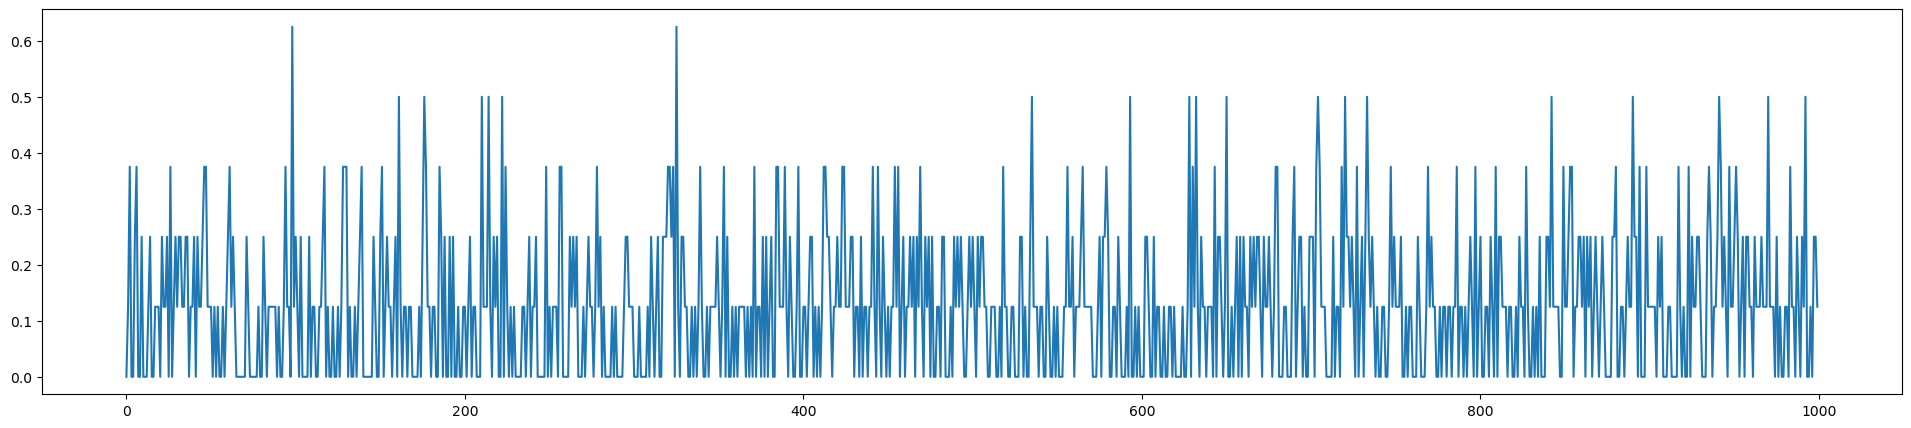

In [4]:
from scipy.stats import poisson

mu = 1
timesteps = 100000

U = poisson.rvs(mu, size=timesteps, random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
U_train1 = (U - U.min()) / (U.max() - U.min())

plt.figure(figsize=(24,5))
plt.plot(range(1000), U_train1[9500:10500])
plt.show()

# Algorithm
https://www.nature.com/articles/s41598-018-22077-3#Fig1

$ \Delta z_i =  \frac {1}{\beta}(target\_r - r_i) $

In [5]:
# helper function
def count_incoming_connexions(W):
    incoming_connexion = W.nonzero()[0]
    incoming_connexion_count = np.zeros(W.shape[0])
    for i in incoming_connexion:
        incoming_connexion_count[i] +=1
    return incoming_connexion_count

## Matrice initialization

In [8]:
# Parameters
n_e = 50 # number of neurons for excitatory pool
n_i = 0 # number of neurons for inhibitory pool
SEED = 3789
leaky_rate = 1
input_scaling = 1

spectral_radius = 0.95
input_connectivity =  0.745
connectivity = 0.075

# HYPERPARAMETERS
INCREMENT = 20
VALUE = 0.1
bias_scaling = 0.6


# Initialisation EE
Win_e, W_ee, bias_e =  init_matrices(n_e, input_connectivity, connectivity, spectral_radius, seed=SEED)
bias_e = bias_e*bias_scaling
Win_e = Win_e*input_scaling

# Initialisation EI
_, W_ei, _ =  init_matrices((n_i, n_e), 0, connectivity, spectral_radius, seed=SEED)

# Initialisation IE
_, W_ie, _ =  init_matrices((n_e, n_i), 0, connectivity, spectral_radius, seed=SEED)

# Initialisation II
_, _, bias_i =  init_matrices(n_i, 0, connectivity, spectral_radius, seed=SEED)
bias_i = bias_i*bias_scaling

# last_state
last_state_e = np.random.uniform(0, 1, n_e)
last_state_i = np.random.uniform(0, 1, n_i)

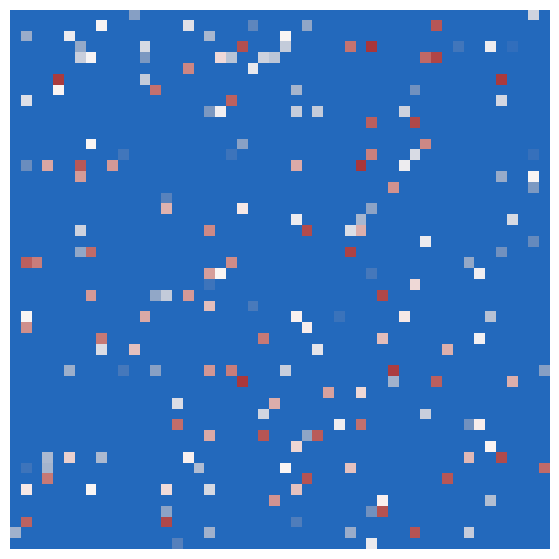

In [9]:
show_ei_matrix(W_ee, W_ei, W_ie)

## Simulation

Excitatory neuron evolution is given by : 

$ r_E^{t+1} = W_{EE}r_E^{t} - W_{IE}r_I^{t} + W_{in}u^{t} + bias_E $

Inhibitory neurons evolution is given by : 

$ r_I^{t+1} = W_{EI}r_E^{t} + bias_I $


In [10]:
import connexion_generation.activity_dependant_connexion
from connexion_generation.activity_dependant_connexion import compute_synaptic_change, add_activity_connexion, add_activity_connexion_for_excitatory, select_pairs_connexion, select_pairs_pruning, change_connexion
reload(connexion_generation.activity_dependant_connexion)

# Parameters
# The parameters you want to see the influence
growth_parameter = 0.1
target_rate=0.7

# Initialisation
W_ee_adsp = W_ee.copy()
W_ie_adsp = W_ie.copy()
W_ei_adsp = W_ei.copy()
U_train3 = U_train1.copy()
state_e = last_state_e
state_i = last_state_i

train_length = len(U_train3)
step=0
convergence_step = 0

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

incoming_connexion_count_history = []
state_history_e = []
state_history_i = []
delta_z_e_history = []
delta_z_i_history = []

for i in range(INCREMENT*5):
    state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, U_train3[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
    state_history_e.append(state_e)
    state_history_i.append(state_i)
U_train3 = U_train3[INCREMENT*5:]

In [11]:
while total_add + total_prun < 5000 and train_length > 5000:

    incoming_connexion_count_history.append(count_incoming_connexions(W_ee_adsp))

    # For excitatory neurons
    delta_z_e = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, time_window = INCREMENT)
    delta_z_e_history.append(delta_z_e)
    # Plasticity for both We and Wie
    W_ee_adsp, W_ie_adsp, nb_new_add_e, nb_new_prun_e = add_activity_connexion_for_excitatory(W_ee_adsp, W_ie_adsp, state_e, delta_z_e, VALUE)
    # Only Wee plasticity
    # W_ee_adsp, nb_new_add, nb_new_prun = add_activity_connexion(W_ee_adsp, state_e, delta_z_e, VALUE)
    
    # For inhibitory neurons
    delta_z_i = compute_synaptic_change(state_history_i[-INCREMENT:], target_rate, growth_parameter, time_window = INCREMENT)
    delta_z_i_history.append(delta_z_i)
    W_ei_adsp, nb_new_add_i, nb_new_prun_i = add_activity_connexion(W_ei_adsp, state_i, delta_z_i, VALUE)
 
    for i in range(INCREMENT):
        state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, U_train3[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
        state_history_e.append(state_e)
        # state_history_i.append(state_i)
        
    U_train3 = U_train3[INCREMENT:]
    train_length = len(U_train3)
    length = len(U_train3)
    total_add += nb_new_add_e + nb_new_add_i
    total_prun += nb_new_prun_e + nb_new_prun_i
    add.append(total_add)
    prun.append(total_prun)
    if step > 5 and convergence_step == 0:
        mean_add = (add[-1]-add[-5])/2
        mean_prun = (prun[-1]-prun[-5])/2
        if prun[3] > add[3] and mean_add >= mean_prun: 
            convergence_step = step
        if prun[3] < add[3] and mean_add <= mean_prun: 
            convergence_step = step
    step +=1
add = np.array(add)
prun = np.array(prun)

## Analysis

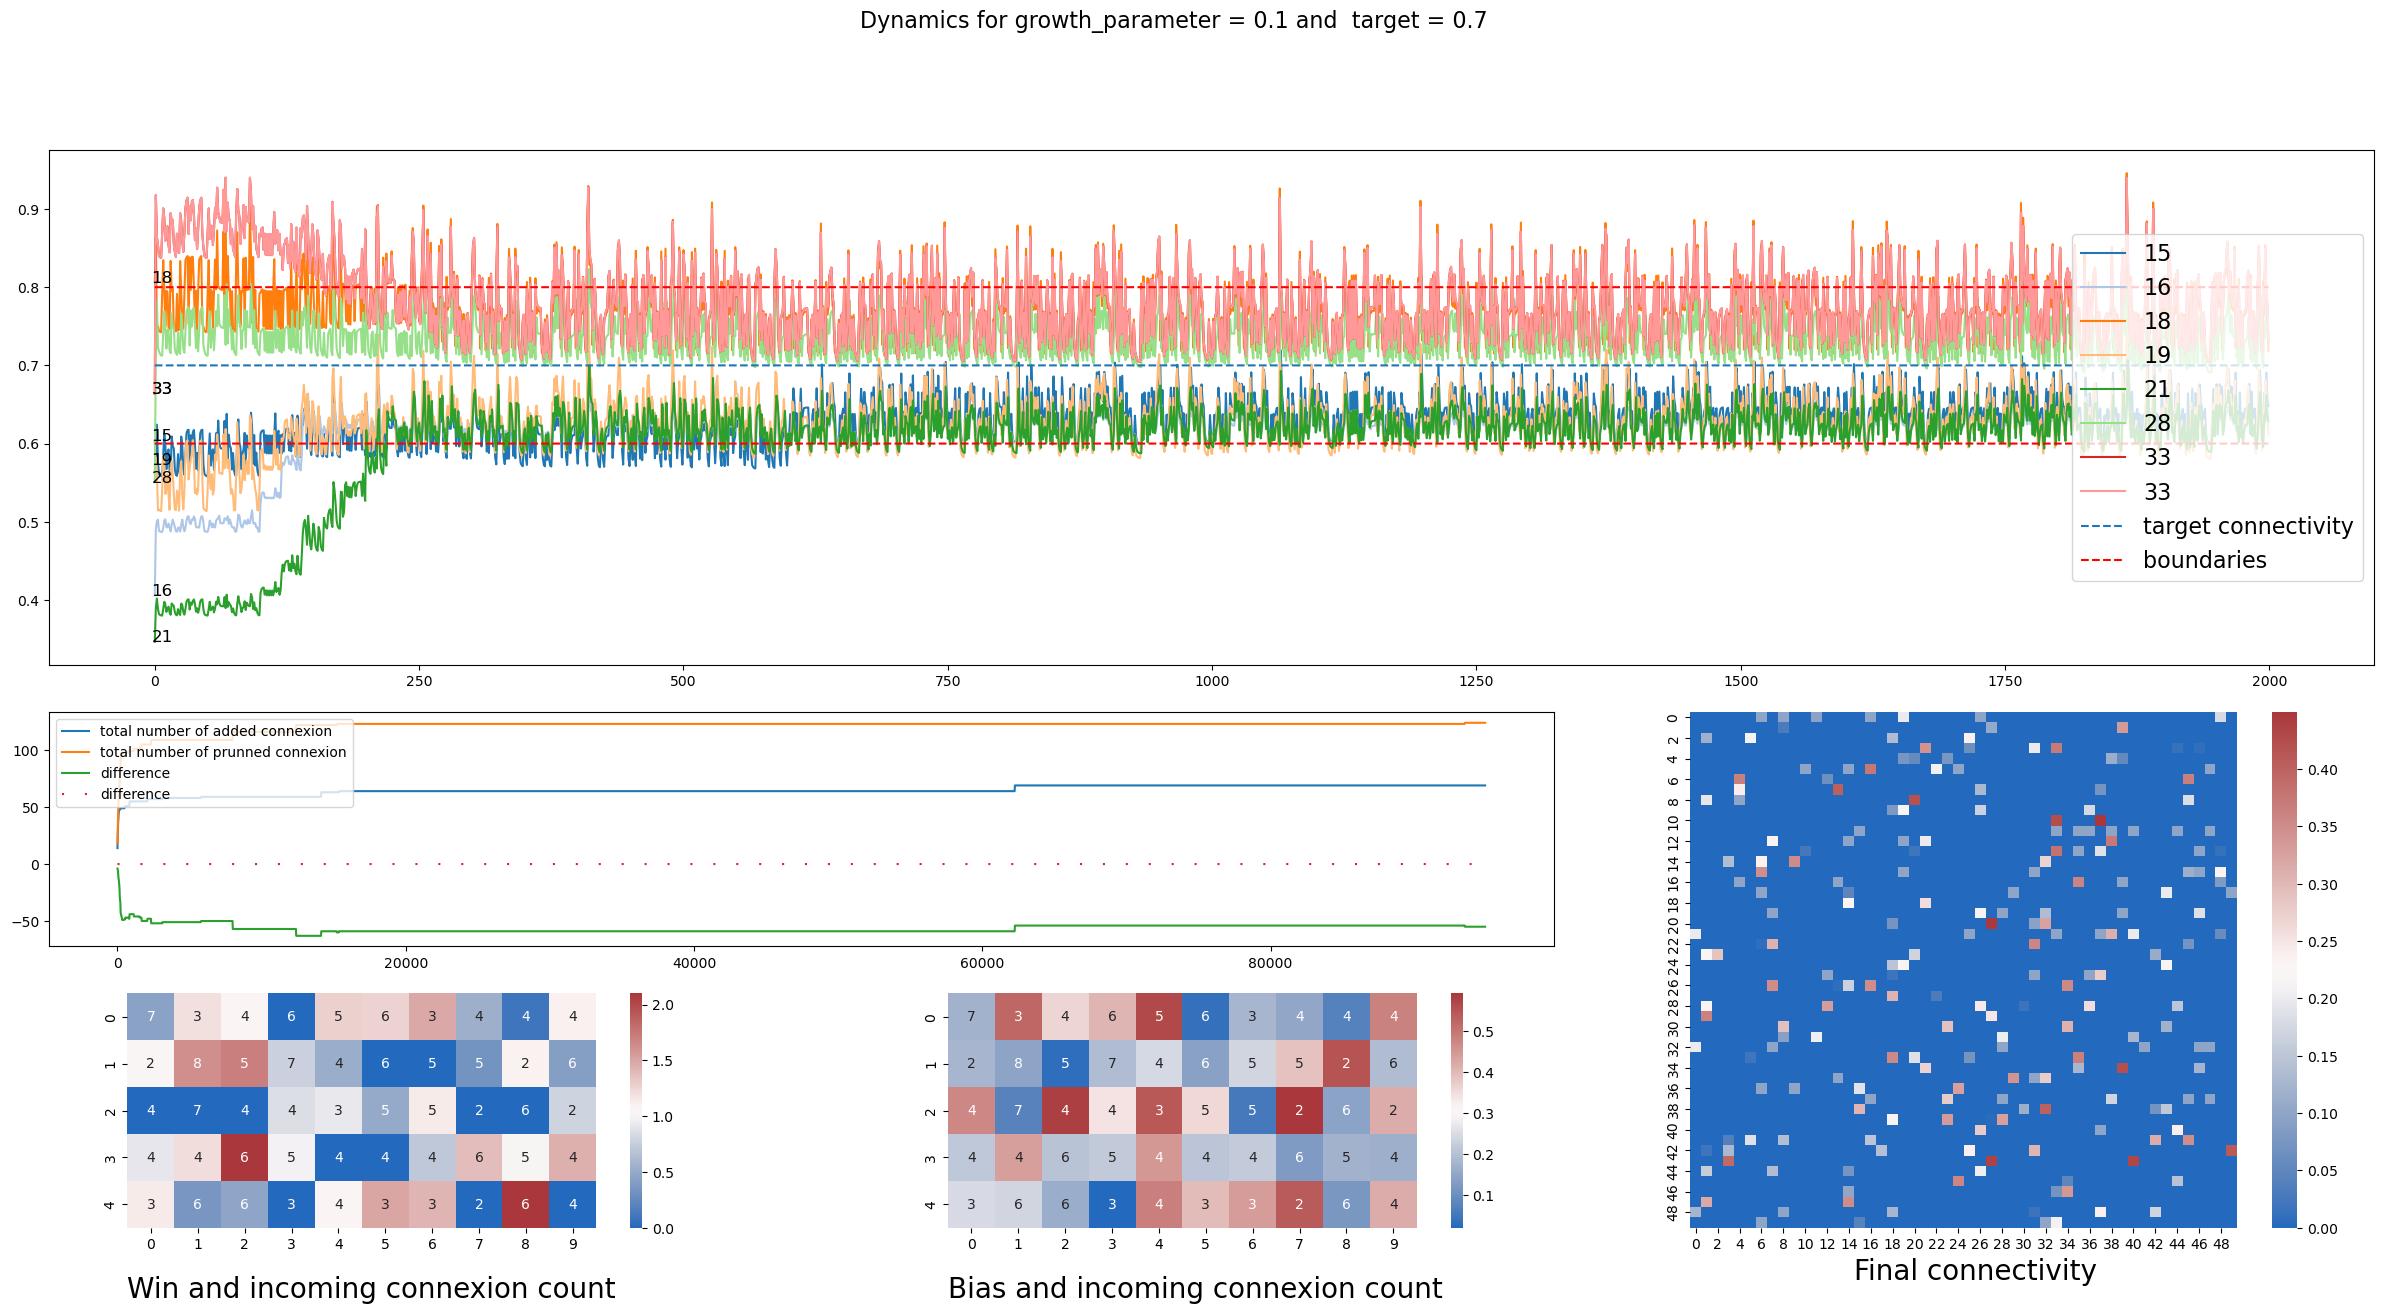

In [14]:
from math import copysign

plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics for growth_parameter = {growth_parameter} and  target = {target_rate}', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(n_e, size=8)) #Size max is 19 because there is not enough colors
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 0
WATCH_TO = 2000
neurons_evolution = np.array(state_history_e)[WATCH_FROM:WATCH_TO]
x =range(step*INCREMENT)[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
ax0.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="target connectivity")
ax0.plot(x, [target_rate+growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--", label="boundaries")
ax0.plot(x, [target_rate-growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--")

plt.legend(fontsize=16, loc="right")


# TOTAL ADDITION AND PRUNING OF CONNEXIONS 
ax1 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax1.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
ax1.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
ax1.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
ax1.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)), label="difference")
ax1.legend()

ax2 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)
heatmap(W_ee_adsp.todense(), cmap=color_palette("vlag", as_cmap=True), ax = ax2)
ax2.text(15,55, 'Final connectivity',fontsize=20)

ax3 = plt.subplot2grid((4, 3), (3, 0))
heatmap(Win_e.A.reshape(5,10), square=True, cmap=color_palette("vlag", as_cmap=True)
            , annot = incoming_connexion_count_history[-1].reshape(5,10), ax = ax3)
ax3.text(0, 6.5, 'Win and incoming connexion count',fontsize=20)

ax4 = plt.subplot2grid((4, 3), (3, 1))
heatmap(bias_e.reshape(5,10), square=True, cmap=color_palette("vlag", as_cmap=True)
            , annot = incoming_connexion_count_history[-1].reshape(5,10), ax = ax4)
ax4.text(0, 6.5, 'Bias and incoming connexion count',fontsize=20)

plt.show()

# Measurement

## Richness in reservoir

### Memory capacity

$$  y_{d_i} = \prod_i{P_{d_i}(u(t-i))}$$

#### Without adsp

In [ ]:
# Number of time steps: you can use 1e5 for quick-and-dirty, but 1e6 is better
warmup_steps = 500
warmups = 2.0*np.random.rand(warmup_steps,1)-1.0

# Important: capacity theory with Legendre polynomials assumes uniform random inputs in [-1,1]
steps = 1000000
inputs = 2.0*np.random.rand(steps,1)-1.0

for i in range(warmup_steps):
    state_e, state_i = update_ei_reservoir(W_ee, W_ie, W_ei, Win_e, warmups[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)

capa_history_e = []
for i in range(steps):
    state_e, state_i = update_ei_reservoir(W_ee, W_ie, W_ei, Win_e, inputs[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
    capa_history_e.append(state_e)
capa_history_e = np.array(capa_history_e)

In [ ]:
import analysis.capacities as CAP

# Measallcapsure capacities on inputs and states after removing a "warmup period"
# If you require more extensive printed output of individual capacities:
# set verbose = 1
Citer=CAP.capacity_iterator(maxdeg=7)#, verbose = 1)
totalcap,allcaps,numcaps,nodes = Citer.collect(inputs,capa_history_e)

print("\nMeasured ",numcaps," capacities above threshold.\nTotal capacity = ",totalcap)

In [ ]:
# Helper function to use the capacities data structure coming out of the iterator
# cap2vec collates all capacities with same maximal delay and degree up to given maximal values
def cap2vec(capacities,maxdel=1000,maxdeg=10):
    vec = np.zeros((maxdel,maxdeg))
    for idx in range(len(capacities)):
        delay=capacities[idx]['delay']
        degree=capacities[idx]['degree']
        if (delay<=maxdel) and (degree<=maxdeg):
            vec[delay-1,degree-1]+=capacities[idx]['score']
    return vec

maxdel = 100
maxdeg = 10
V = cap2vec(allcaps,maxdel = maxdel, maxdeg = maxdeg)

delrange = np.arange(1,maxdel+1)
totcap = np.sum(V,axis=1)
plt.figure()
plt.semilogy(delrange,V[:,0],label='Linear')
plt.plot(delrange,V[:,1],label='Qadratic')
plt.plot(delrange,V[:,2],label='Qubic')
plt.plot(delrange,V[:,3],label='4')
plt.plot(delrange,V[:,4],label='5')

plt.xlabel('Maximal delay')
plt.ylabel('Total capacity')
plt.legend()
plt.show()

In [ ]:
maxdel1 = 25000
maxdeg1 = 6
delrange1 = np.arange(1,maxdel1+1)
plt.figure()
V1 = cap2vec(allcaps,maxdel = maxdel1, maxdeg = maxdeg1)
totcap1 = np.sum(V1,axis=1)
plt.semilogy(delrange1[0:20],V1[:,0][0:20],label='Linear')

plt.xlabel('Maximal delay')
plt.ylabel('Total capacity')
plt.legend()
plt.show()

#### With adsp

In [ ]:
# Number of time steps: you can use 1e5 for quick-and-dirty, but 1e6 is better
warmup_steps = 500
warmups = 2.0*np.random.rand(warmup_steps,1)-1.0

# Important: capacity theory with Legendre polynomials assumes uniform random inputs in [-1,1]
steps = 1000000
inputs = 2.0*np.random.rand(steps,1)-1.0

state_e_adsp = last_state_e
state_i_adsp = last_state_i
for i in range(warmup_steps):
    state_e_adsp, state_i_adsp = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, warmups[i], state_e_adsp, state_i_adsp, leaky_rate, bias_e, bias_i, activation_function)

capa_history_e_adsp = []
for i in range(steps):
    state_e_adsp, state_i_adsp = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, inputs[i], state_e_adsp, state_i_adsp, leaky_rate, bias_e, bias_i, activation_function)
    capa_history_e_adsp.append(state_e_adsp)
capa_history_e_adsp = np.array(capa_history_e_adsp)

In [ ]:
import analysis.capacities as CAP

# Measallcapsure capacities on inputs and states after removing a "warmup period"
# If you require more extensive printed output of individual capacities:
# set verbose = 1
Citer=CAP.capacity_iterator(maxdeg=7)#, verbose = 1)
totalcap_adsp,allcaps_adsp,numcaps_adsp,nodes = Citer.collect(inputs,capa_history_e_adsp)

print("\nMeasured ",numcaps_adsp," capacities above threshold.\nTotal capacity = ",totalcap_adsp)

In [ ]:
maxdel = 100
maxdeg = 10
V = cap2vec(allcaps_adsp,maxdel = maxdel, maxdeg = maxdeg)

delrange = np.arange(1,maxdel+1)
totcap = np.sum(V,axis=1)
plt.figure()
plt.semilogy(delrange,V[:,0],label='Linear')
plt.plot(delrange,V[:,1],label='Qadratic')
plt.plot(delrange,V[:,2],label='Qubic')
plt.plot(delrange,V[:,3],label='4')
plt.plot(delrange,V[:,4],label='5')

plt.xlabel('Maximal delay')
plt.ylabel('Total capacity')
plt.legend()
plt.show()

In [ ]:
maxdel1 = 25000
maxdeg1 = 6
delrange1 = np.arange(1,maxdel1+1)
plt.figure()
V1 = cap2vec(allcaps_adsp,maxdel = maxdel1, maxdeg = maxdeg1)
totcap1 = np.sum(V1,axis=1)
plt.semilogy(delrange1[0:20],V1[:,0][0:20],label='Linear')

plt.xlabel('Maximal delay')
plt.ylabel('Total capacity')
plt.legend()
plt.show()

### Uncoupled dynamics

number of the principal components (i.e. orthogonal diretions of variability) that are able to explain the most of the variance in the reservoir state space

https://arxiv.org/pdf/1903.05174.pdf

$$ UD =  \underset{d}{\arg\min} \{ \sum\limits_{k=1}^d R_k|\sum\limits_{k=1}^dR_k ≥ A\}$$

with  $R_k = \frac{σ_k}{\sum\limits_{j=1}^{N_R}σ_j} $

In [ ]:
from analysis.metrics import uncoupled_dynamics
from reservoirpy.datasets import mackey_glass
from reservoirpy.observables import nrmse, rsquare

timesteps = 20000
warmup_steps = 500
steps = timesteps + warmup_steps
tau = 17
# X = mackey_glass(steps, tau=tau)
X = 2.0*np.random.rand(steps,1)-1.0
# rescale between -1 and 1
inputs = 2 * (X - X.min()) / (X.max() - X.min()) - 1

## Calculous for simple RNN
state_e = last_state_e
state_i = last_state_i
history_e = []
for i in range(steps):
    state_e, state_i = update_ei_reservoir(W_ee, W_ie, W_ei, Win_e, inputs[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
    history_e.append(state_e)
history_e = np.array(history_e)[warmup_steps:]
UD = uncoupled_dynamics(history_e, temp = 5000, A= 0.9)
print(UD)

## Calculous for adsp RNN
state_e_adsp = last_state_e
state_i_adsp = last_state_i
history_e_adsp = []
for i in range(steps):
    state_e_adsp, state_i_adsp = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, inputs[i], state_e_adsp, state_i_adsp, leaky_rate, bias_e, bias_i, activation_function)
    history_e_adsp.append(state_e_adsp)
history_e_adsp = np.array(history_e_adsp)[warmup_steps:]
UD_adsp = uncoupled_dynamics(history_e_adsp, temp = 5000, A= 0.9)

print(UD_adsp)


### Pearson coeffcients

$$ corr(x_i(t), x_k(t+1))) = \frac{\sum\limits_{t=1}^{T-1}{(x_i(t)-\bar{x_i})(x_k(t)-\bar{x_k})}} {\sqrt{\sum\limits_{t=1}^{T-1}{(x_i(t)-\bar{x_i})^2}}\sqrt{\sum\limits_{t=1}^{T-1}{(x_k(t)-\bar{x_k})^2}}} $$

In [ ]:
from analysis.metrics import pearson_matrix

plt.figure(figsize=(12,4))

ax0 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
Pearson = pearson_matrix(history_e_adsp[:20000,])
heatmap(Pearson)

ax1 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
Pearson = pearson_matrix(history_e[:20000,])
heatmap(Pearson)

The mean Pearson coefficient is given by

$$ \bar{Corr} = \frac{1}{N^2} \sum\limits_{i=1}^{N}\sum\limits_{k=1}^{N}corr(x_i(t), x_k(t+1)) $$

In [ ]:
print(np.mean(pearson_matrix(history_e[:20000,])))
print(np.mean(pearson_matrix(history_e_adsp[:20000,])))

### Average State Entropy

efficient estimator of Renyi’s quadratic entropy 

https://arxiv.org/pdf/1903.05174.pdf

https://www.researchgate.net/publication/2818138_Information-Theoretic_Learning_Using_Renyi's_Quadratic_Entropy4

*"H(t) which is the sum of all pairs of interactions can be regarded as an overall potential energy of the data set. We will call this potential energy an information potential (IP). So **maximizing entropy** becomes equivalent to **minimizing information potential**"*


https://ia800704.us.archive.org/view_archive.php?archive=/24/items/wikipedia-scholarly-sources-corpus/10.1162.zip&file=10.1162%252Fneco.2007.19.1.111.pdf



$$H(t) = −log( \frac{1}{N_R^2}\sum\limits_{j=1}^{N_R}(\sum\limits_{i=1}^{N_R}G _{0.3}(x_j(t) - x_i (t))))$$

In [ ]:
from analysis.metrics import renyi_entropy

In [ ]:
print(np.mean(renyi_entropy(history_e[:20000,])))
print(np.mean(renyi_entropy(history_e_adsp[:20000,])))

## Topology

In [ ]:
%matplotlib inline
%matplotlib --list

In [ ]:
from analysis.topology import create_network, draw_network

g = create_network(W_ee, Win_e)
draw_network(g, n_e)

In [ ]:
g = create_network(W_ee_adsp)
draw_network(g, n_e)

### Connexion number histogram

In [ ]:
# Incoming connexions histogram
def plot_incoming_co_histogram(W_ee, W_ei, W_ie, ax=None):
    connections_ee = np.sum(np.where(W_ee <= 0, W_ee, 1), axis=1)
    connections_ie = np.sum(np.where(W_ie <= 0, W_ie, 1), axis=1)
    incoming_co = connections_ee + connections_ie
#    print(incoming_co)
    n_bins = int(np.max(incoming_co)+1)
    if ax == None:
        plt.figure()
        ax = plt
    ax.hist(incoming_co, bins=n_bins, ec="yellow")

# Incoming connexions histogram
def plot_outcoming_co_histogram(W_ee, W_ei, W_ie, ax=ax1):
    connections_ee = np.sum(np.where(W_ee <= 0, W_ee, 1), axis=0)
    connections_ie = np.sum(np.where(W_ei <= 0, W_ei, 1), axis=0)
    incoming_co = connections_ee + connections_ie
#    print(incoming_co)
    n_bins = int(np.max(incoming_co)+1)
    if ax == None:
        plt.figure()
        ax = plt
    ax.hist(incoming_co, bins=n_bins, ec="yellow")

fig = plt.figure(figsize=(16,8))

gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
plot_incoming_co_histogram(W_ee.A, W_ei.A, W_ie.A, ax=ax1)
ax1.set_ylabel("connexions before adsp")
ax1.set_title("Incoming connexions")


ax2 = fig.add_subplot(gs[0, 1])
plot_outcoming_co_histogram(W_ee.A, W_ei.A, W_ie.A, ax=ax2)
ax2.set_title("Outcoming connexions")

ax3 = fig.add_subplot(gs[1, 0])
plot_incoming_co_histogram(W_ee_adsp.A, W_ei_adsp.A, W_ie_adsp.A, ax=ax3)
ax3.set_ylabel("connexions after adsp")

ax4 = fig.add_subplot(gs[1, 1])
plot_outcoming_co_histogram(W_ee_adsp.A, W_ei_adsp.A, W_ie_adsp.A, ax=ax4)


In [ ]:
from graph_tool.all import GraphView, corr_hist
g = create_network(W_ee)

gv= GraphView(g, directed=False)
h = corr_hist(g, "out", "out")

plt.clf()
plt.xlabel("Source out-degree")

plt.ylabel("Target out-degree")

plt.imshow(h[0].T, interpolation="nearest", origin="lower")

plt.colorbar()


### Centrality
https://graph-tool.skewed.de/static/doc/centrality.html?highlight=eigentrust#graph_tool.centrality.eigentrust

#### Katz centrality

In [ ]:
# The Katz centrality is the solution of the nonhomogeneous linear system x = alpha * A * x + betha
# https://en.wikipedia.org/wiki/Katz_centrality
# https://graph-tool.skewed.de/static/doc/centrality.html#graph_tool.centrality.katz
from graph_tool.all import katz, graph_draw, prop_to_size, arf_layout
import matplotlib

g = create_network(W_ee)

x = katz(g, weight=g.ep["edge_pen_weight"])
pos = arf_layout(g)

graph_draw(g, pos=pos, vertex_fill_color=x,
              vertex_size=prop_to_size(x, mi=5, ma=15),
              vcmap=matplotlib.cm.gist_heat,
              vorder=x)

#### EigenTrust

In [ ]:
# The Katz centrality is the solution of the nonhomogeneous linear system x = alpha * A * x + betha
# https://en.wikipedia.org/wiki/EigenTrust
# https://graph-tool.skewed.de/static/doc/centrality.html?highlight=eigentrust#graph_tool.centrality.eigentrust
from graph_tool.all import eigentrust, graph_draw, prop_to_size
import matplotlib

g = create_network(W_ee)

t = eigentrust(g, g.ep["edge_pen_weight"])
pos = arf_layout(g)

graph_draw(g, pos=pos, vertex_fill_color=t,
              vertex_size=prop_to_size(t, mi=5, ma=15),
              vcmap=matplotlib.cm.gist_heat,
              vorder=t)

### Shortest path

In [ ]:
from graph_tool.all import count_shortest_paths

g = create_network(W_ee)
n_paths = count_shortest_paths(g, 12, 35)

print(n_paths)

### Correlation
https://graph-tool.skewed.de/static/doc/correlations.html#graph_tool.correlations.corr_hist

In [ ]:
from graph_tool.all import GraphView, assortativity, scalar_assortativity
g = create_network(W_ee)

# Return the assortativity coefficient, and its variance.
gv= GraphView(g, directed=False)
print(assortativity(gv, "out"))
print(scalar_assortativity(gv, "out"))

# Benchmarks

https://www.sciencedirect.com/science/article/pii/S092523122100775X?via%3Dihub


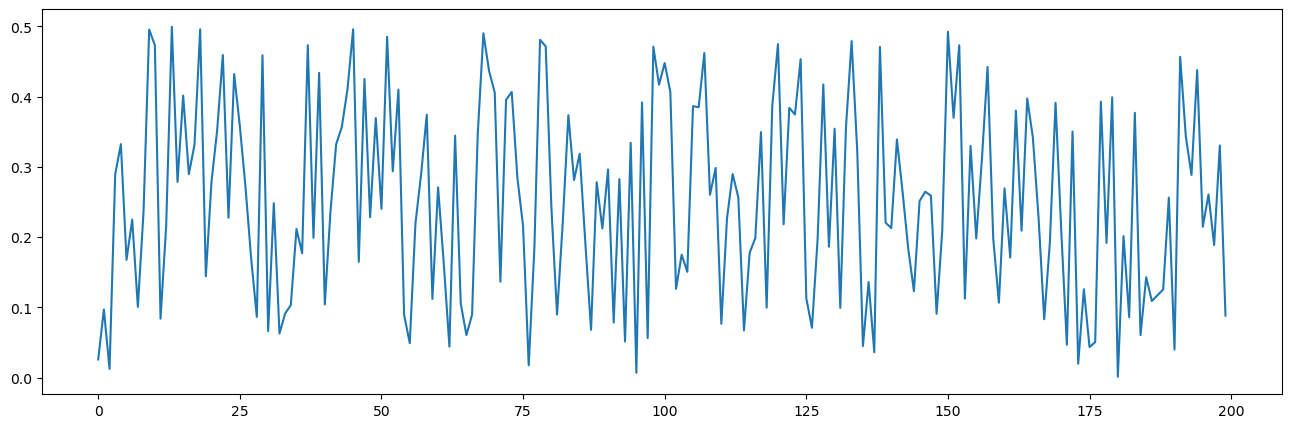

In [15]:
def createNARMA(length=10000, system_order=10, coef = [.3, .05, 1.5, .1]):

    inputs = np.random.rand(length, 1) * .5
    inputs.shape = (-1, 1)
    outputs = np.zeros((length, 1))
    for k in range(system_order - 1, length - 1):
        outputs[k + 1] = coef[0] * outputs[k] + coef[1] * \
                                           outputs[k] * np.sum(outputs[k - (system_order - 1):k + 1]) + \
                         coef[2] * inputs[k - (system_order-1)] * inputs[k] + coef[3]
    return inputs, outputs


def createNARMA10(length=10000):
    return createNARMA(length=length, system_order=10, coef=[.3, .05, 1.5, .1])


def createNARMA30(length=10000):
    return createNARMA(length=length, system_order=30, coef=[.2, .04, 1.5, .001])


timesteps = 100000 
train_samples = 10000
test_lenght = 5000

u, y = createNARMA30(timesteps)

U_train, y_train = u[:train_samples], y[:train_samples]
U_test, y_test = u[train_samples:], y[train_samples:]

%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(range(200), U_train[:200])
plt.show()

## Ridge search throughout cross validation

In [32]:
from sklearn.model_selection import TimeSeriesSplit
from reservoir.losses import nrmse

# k -fold walk forward validation
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]
            
# Parameters
mean_nrmse_list = []
ridge_coef_list = []

# Index spliting
n_fold = 4
tscv = BlockingTimeSeriesSplit(n_splits=n_fold)

for ridge_coef in np.logspace(-10, 3,  num=20):
    for train_index, val_index in tscv.split(U_train):
#        print("TRAIN:", train_index[0], val_index[-1], "VALIDATION:", test_index[0], val_index[-1]) 
        U_cv_train, U_cv_val = U_train[train_index], U_train[val_index]
        y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]

        mean_nrmse = 0


        # Training output
        Wout, b_out, last_state_e, last_state_i = train_ei(W_ee, W_ie, W_ei, Win_e, bias_e, bias_i, U_cv_train, y_cv_train, activation_function, ridge_coef = ridge_coef)

        # Prediction
        y_cv_pred = run_ei(W_ee, W_ie, W_ei, Win_e, bias_e, bias_i, Wout, U_cv_val, activation_function, b_out, 1, last_state_e, last_state_i)
        mean_nrmse = mean_nrmse + float(nrmse(y_cv_pred, y_cv_val))/n_fold

    mean_nrmse_list.append(mean_nrmse)
    ridge_coef_list.append(ridge_coef)

min_val_idx = [i for i in range(len(mean_nrmse_list)) if mean_nrmse_list[i]==min(mean_nrmse_list)][0]

print(ridge_coef_list[min_val_idx])

ridge_coef = ridge_coef_list[min_val_idx]

4.832930238571753e-10


## Train 

In [54]:
import reservoir.reservoir
from reservoir.reservoir import train_ei
reload(reservoir.reservoir)

# Training output
Wout, b_out, last_state_e, last_state_i = train_ei(W_ee, W_ie, W_ei, Win_e, bias_e, bias_i, U_train, y_train, activation_function, ridge_coef = ridge_coef)


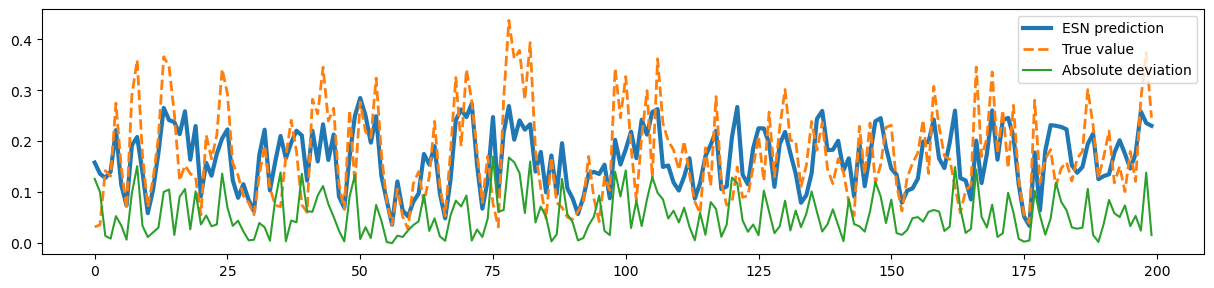

In [61]:
from reservoir.reservoir import run_ei
from reservoir.reservoirpy_util import plot_results, plot_readout

# Prediction
y_pred = run_ei(W_ee, W_ie, W_ei, Win_e, bias_e, bias_i, Wout, U_test, activation_function, b_out, 1, last_state_e, last_state_i)

plot_results(y_pred, y_test, sample=200)

In [55]:
# Training output
Wout_adsp, b_out_adsp, last_state_e_adsp, last_state_i_adsp = train_ei(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, bias_e, bias_i, U_train, y_train, activation_function, ridge_coef = ridge_coef)


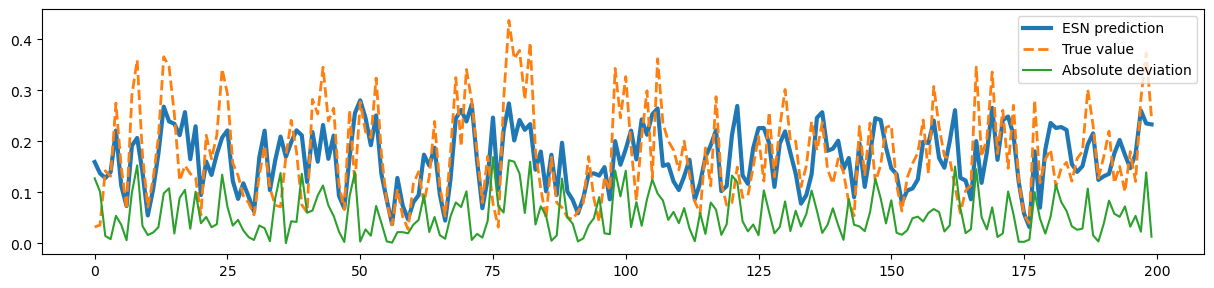

In [62]:
# Prediction
y_pred_adsp = run_ei(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, bias_e, bias_i, Wout_adsp, U_test, activation_function, b_out_adsp, 1, last_state_e_adsp, last_state_i_adsp)

plot_results(y_pred_adsp, y_test, sample=200)

## Root mean square error

$RMSE=\sqrt{\frac{1}{F}\sum\limits_{t=0}^F(y_{pred}(t)−y_{test}(t))^2}$

In [60]:
import reservoir.losses
from reservoir.losses import rmse
reload(reservoir.losses)

print("rmse", float(rmse(y_test[:20000], y_pred[:20000])))
print("rmse adsp", float(rmse(y_test[:20000], y_pred_adsp[:20000])))

rmse 0.0700198040526922
rmse adsp 0.07002507266697709
